In [1]:
import networkx as nx
import numpy as np
import pandas as pd

from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

import community as community_louvain

In [2]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [3]:
data = r'data/network_analysis_edgelist.csv'

df = pd.read_csv(data)
df.head()

,source,target
0,Network science,Network science
1,Network science,Hub (network science)
2,Network science,Network theory
3,Network science,National Science Foundation Network
4,Network science,Efficiency (network science)


In [4]:
G = nx.from_pandas_edgelist(df)

G.remove_edges_from(nx.selfloop_edges(G))

In [5]:
print(nx.info(G))

Graph with 51268 nodes and 76211 edges


In [6]:
# this is network analysis network without labels; uncomment out to draw it; takes a minute

# draw_graph(G, node_size=1, show_names=False, edge_width=0.1)

# Parts of Networks (Components and Communities)

This Jupyter notebook is about clusters and larger parts of the network. We're going to look at two things:
- Connected Components: connected parts of the network
- Communities: smaller subsets of the network that share edges

I may need to shatter this network to create a few components, so I will leave in Page Rank.

# PageRank - Identify Nodes of Interest

In [7]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

,page_rank
Glossary of graph theory,0.000341
List of statistics articles,0.000238
Internet,0.000206
Lists of mathematics topics,0.000188
Artificial intelligence,0.000187
Computer network,0.000185
Graph theory,0.000185
Machine learning,0.000180
List of unsolved problems in mathematics,0.000178
List of graph theory topics,0.000171


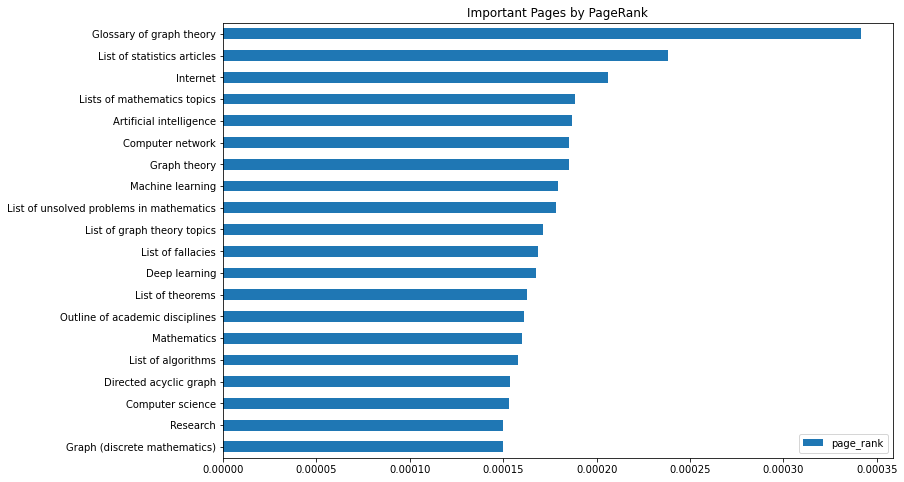

In [8]:
title = 'Important Pages by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

In [9]:
drop_nodes = pr_df.head(20).index.values

G.remove_nodes_from(drop_nodes) 

# only doing this to shatter the network for connected components
# this is only for demonstration. don't do this in practice. these are important nodes.

# Connected Components

I think of connected components as islands or continents in the network, but their definition is not so loose. 

In [10]:
def show_component_sizes(components):

    i = 0

    for c in components:
        
        if len(c) > 1:
            print("{}: {}".format(i, len(c)))
            
        i += 1

In [11]:
components = list(nx.connected_components(G))

In [12]:
len(components)

7

In [13]:
show_component_sizes(components)

0: 51207
1: 10
2: 10
3: 10
4: 9


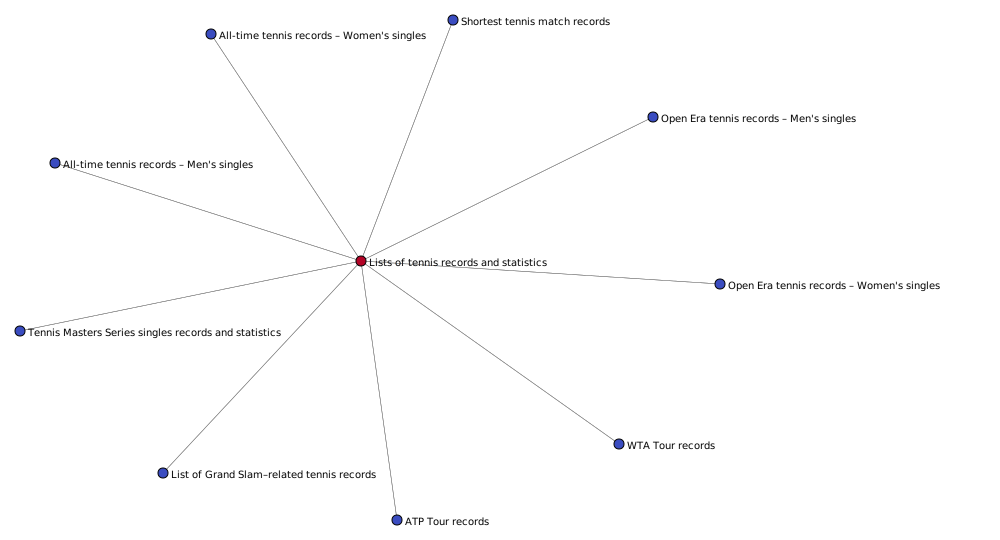

In [14]:
c = components[1]

draw_graph(G.subgraph(c), node_size=5, show_names=True)

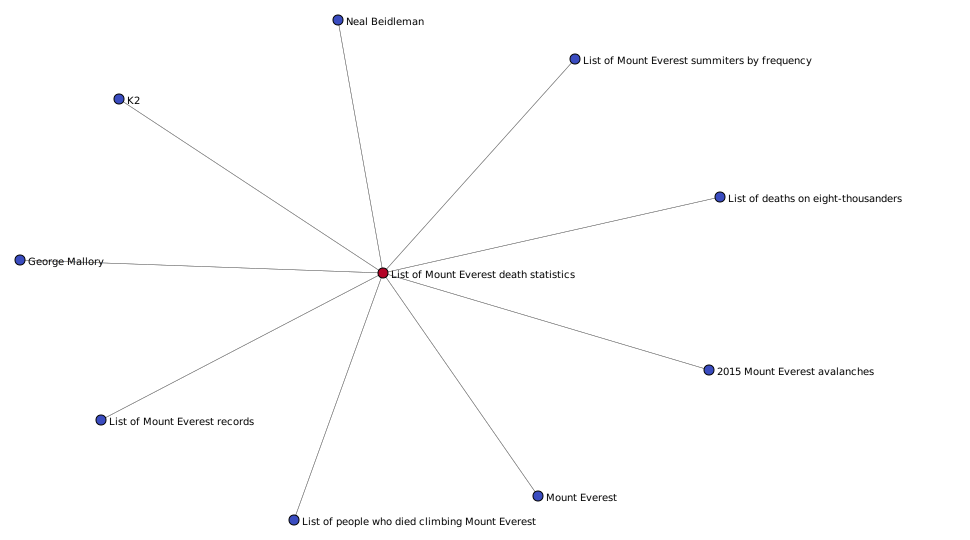

In [15]:
c = components[2]

draw_graph(G.subgraph(c), node_size=5, show_names=True)

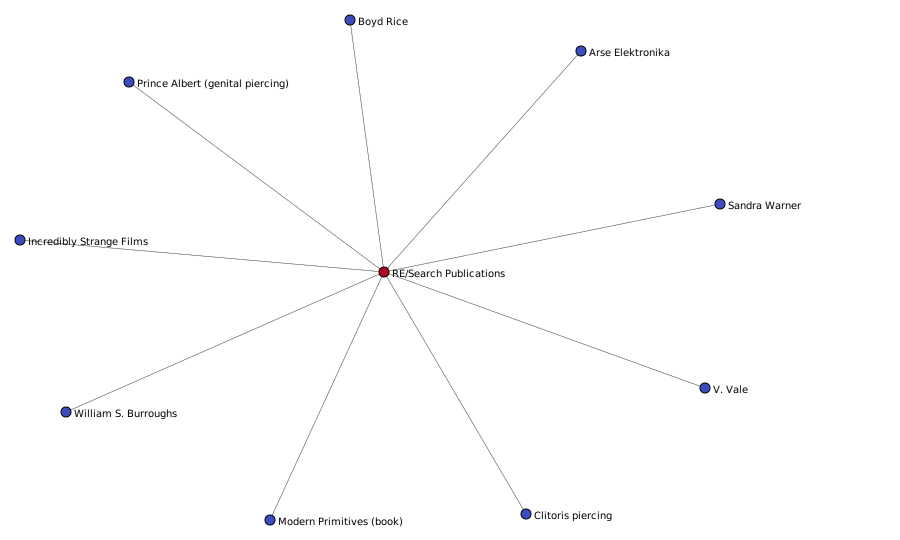

In [16]:
c = components[3]

draw_graph(G.subgraph(c), node_size=5, show_names=True)

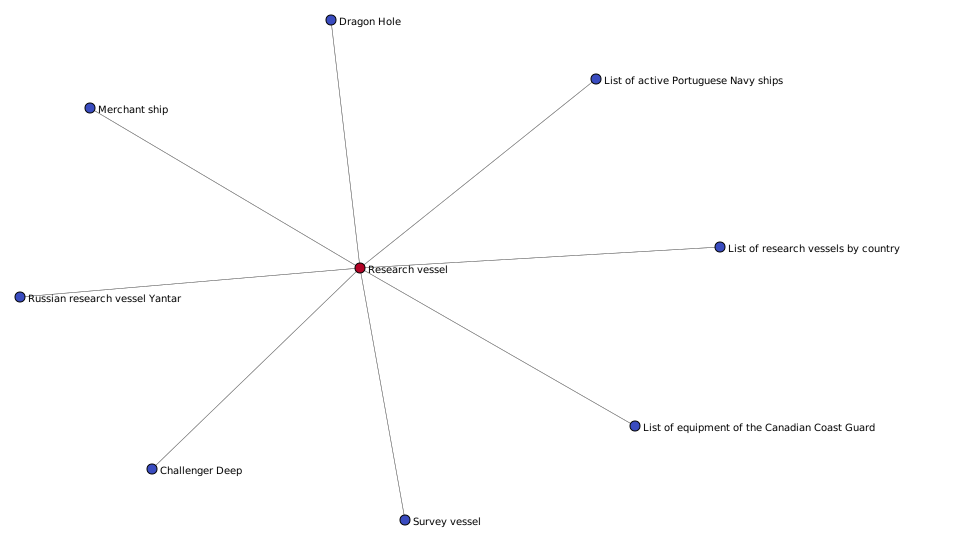

In [17]:
c = components[4]

draw_graph(G.subgraph(c), node_size=5, show_names=True)

In [18]:
G_main = G.subgraph(components[0]) # we will use this for community detection

# Community Detection

We have one large connected component, and this will be great for use in Community Detection. The smaller connected components are communities of their own in this network, split off from the main piece of this network.

In [20]:
def draw_partition(G, partition): 

    import matplotlib.cm as cm 
    import matplotlib.pyplot as plt 

    # draw the graph 
    plt.figure(3,figsize=(12,12)) 
    pos = nx.spring_layout(G) 

    # color the nodes according to their partition 
    cmap = cm.get_cmap('jet', max(partition.values()) + 1) 
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values())) 
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.3) 

    return plt.show() 

In [21]:
partition = community_louvain.best_partition(G_main, resolution=0.1, random_state=1337) 

# we could use draw_partition(G, partition) here, but this will take a long time to render
# let's continue and I'll show a better way to visualize communities; we will use this at the end

# you can use resolution to tweak the community sizes, to get communities to a manageable size
# this is subjective; do what works for you; the point is to identify communities

In [22]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities
community_df = community_df[community_df['node'].str.contains('network|graph|science|inference')]

community_df['community'].value_counts()[0:20]

10     146
185     42
15      39
33      38
4       28
328     26
7       26
324     24
9       23
337     22
41      20
167     20
166     18
0       17
134     16
51      16
402     15
429     14
14      13
284     12
Name: community, dtype: int64

In [23]:
comm_idx = community_df['community'].value_counts()[0:20].index.values
comm_idx

array([ 10, 185,  15,  33,   4, 328,   7, 324,   9, 337,  41, 167, 166,
         0, 134,  51, 402, 429,  14, 284], dtype=int64)

## Exploring Communities

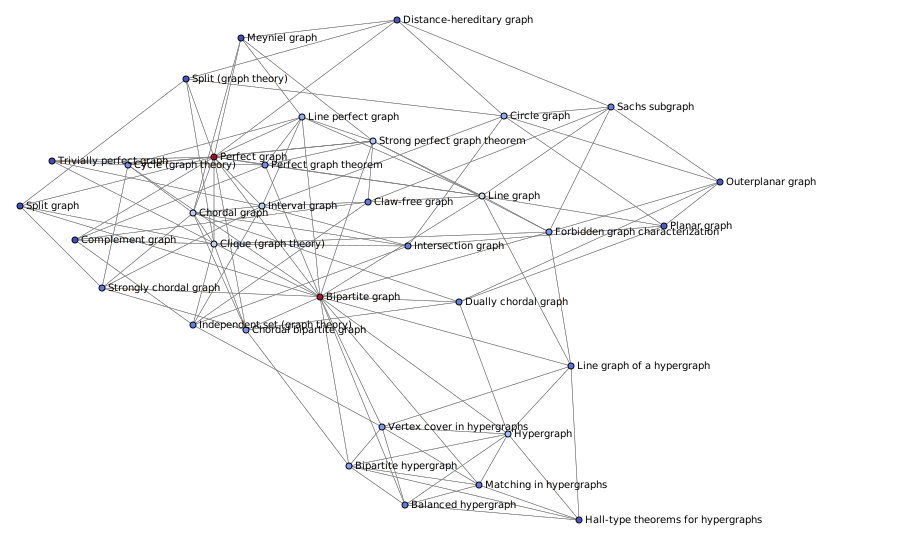

In [24]:
nodes = community_df[community_df['community']==comm_idx[0]]['node'].values

G_comm = G.subgraph(nodes)
G_net_main = G_comm.copy() # we will run community detection off of this at the end

draw_graph(nx.k_core(G_comm, 5), show_names=True, node_size=3)

In [25]:
[print(n) for n in sorted(G_comm.nodes)]

1-planar graph
Apex graph
Balanced hypergraph
Biconnected graph
Bidirected graph
Bipartite graph
Bipartite hypergraph
Block graph
Bramble (graph theory)
Bull graph
Butterfly graph
Cactus graph
Cage (graph theory)
Cartesian product of graphs
Cayley graph
Chordal bipartite graph
Chordal graph
Chvátal graph
Circle graph
Circulant graph
Claw-free graph
Clique (graph theory)
Clique graph
Clique graph (disambiguation)
Closed graph property
Closed graph theorem (functional analysis)
Code property graph
Cograph
Colin de Verdière graph invariant
Complement graph
Complete bipartite graph
Conway's 99-graph problem
Covering graph
Crossing number (graph theory)
Crown graph
Cubic graph
Cycle (graph theory)
Cycle graph
Cycle graph (algebra)
Cyclic graph
Degeneracy (graph theory)
Dense graph
Desargues graph
Dimension (graph theory)
Distance-hereditary graph
Distance-regular graph
Distance-transitive graph
Dual graph
Dually chordal graph
Dürer graph
Edge-transitive graph
Factor graph
Forbidden graph ch

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## More Communities!

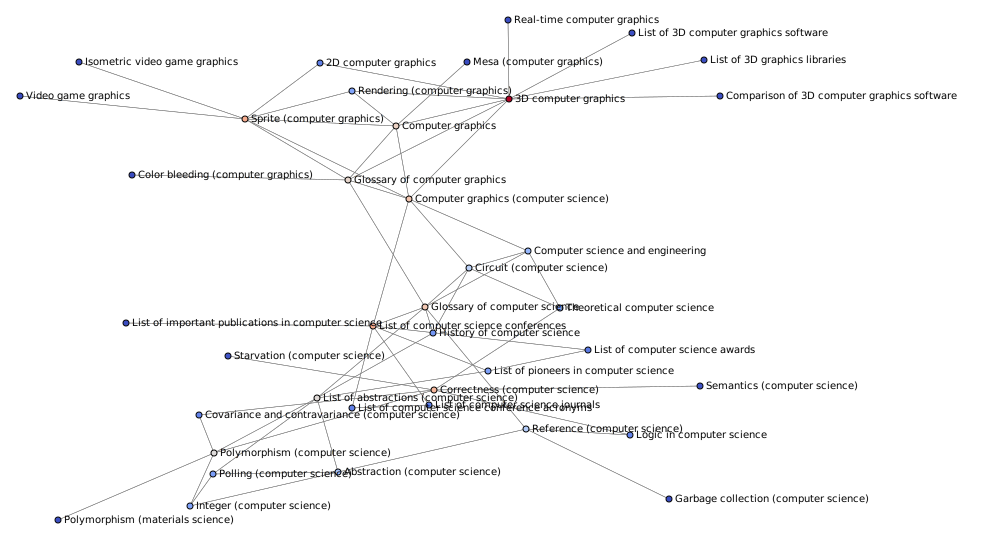

In [26]:
nodes = community_df[community_df['community']==comm_idx[1]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [27]:
[print(n) for n in sorted(G_comm.nodes)]

2D computer graphics
3D computer graphics
Abstraction (computer science)
Circuit (computer science)
Color bleeding (computer graphics)
Comparison of 3D computer graphics software
Computer graphics
Computer graphics (computer science)
Computer science and engineering
Correctness (computer science)
Covariance and contravariance (computer science)
Garbage collection (computer science)
Glossary of computer graphics
Glossary of computer science
History of computer science
Integer (computer science)
Isometric video game graphics
Learning sciences
List of 3D computer graphics software
List of 3D graphics libraries
List of abstractions (computer science)
List of computer science awards
List of computer science conference acronyms
List of computer science conferences
List of computer science journals
List of important publications in computer science
List of pioneers in computer science
Logic in computer science
Mesa (computer graphics)
Node (computer science)
Polling (computer science)
Polymor

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

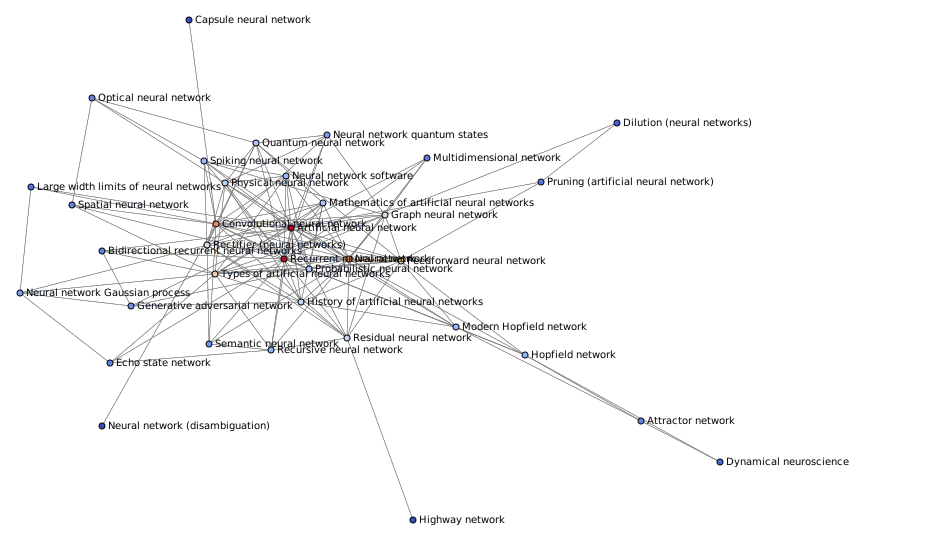

In [28]:
nodes = community_df[community_df['community']==comm_idx[2]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [29]:
[print(n) for n in sorted(G_comm.nodes)]

Artificial neural network
Attractor network
Bidirectional recurrent neural networks
Capsule neural network
Convolutional neural network
Deep belief network
Dilution (neural networks)
Dynamical neuroscience
Echo state network
Feedforward (behavioral and cognitive science)
Feedforward neural network
Generative adversarial network
Graph neural network
Highway network
History of artificial neural networks
Holographic associative memory
Hopfield network
Large width limits of neural networks
Mathematics of artificial neural networks
Modern Hopfield network
Multidimensional network
Neural network
Neural network (disambiguation)
Neural network Gaussian process
Neural network quantum states
Neural network software
Optical neural network
Physical neural network
Probabilistic neural network
Pruning (artificial neural network)
Quantum neural network
Rectifier (neural networks)
Recurrent neural network
Recursive neural network
Residual neural network
Semantic neural network
Spatial neural network
S

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

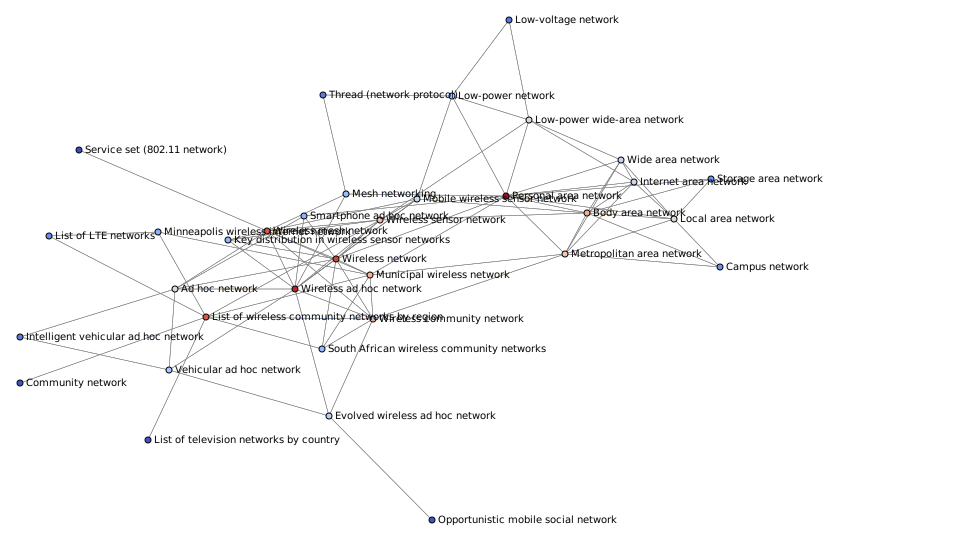

In [30]:
nodes = community_df[community_df['community']==comm_idx[3]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [31]:
[print(n) for n in sorted(G_comm.nodes)]

Ad hoc network
Body area network
Campus network
Community network
Evolved wireless ad hoc network
Intelligent vehicular ad hoc network
Internet area network
Key distribution in wireless sensor networks
List of LTE networks
List of television networks by country
List of wireless community networks by region
Local area network
Low-power network
Low-power wide-area network
Low-voltage network
Mesh networking
Metropolitan area network
Minneapolis wireless internet network
Mobile wireless sensor network
Municipal wireless network
Near-me area network
Opportunistic mobile social network
Personal area network
Routing in delay-tolerant networking
Service set (802.11 network)
Smartphone ad hoc network
South African wireless community networks
Storage area network
Thread (network protocol)
Vehicular ad hoc network
Wide area network
Wireless ad hoc network
Wireless community network
Wireless mesh network
Wireless network
Wireless network organizations by size
Wireless sensor network
Wireless tele

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

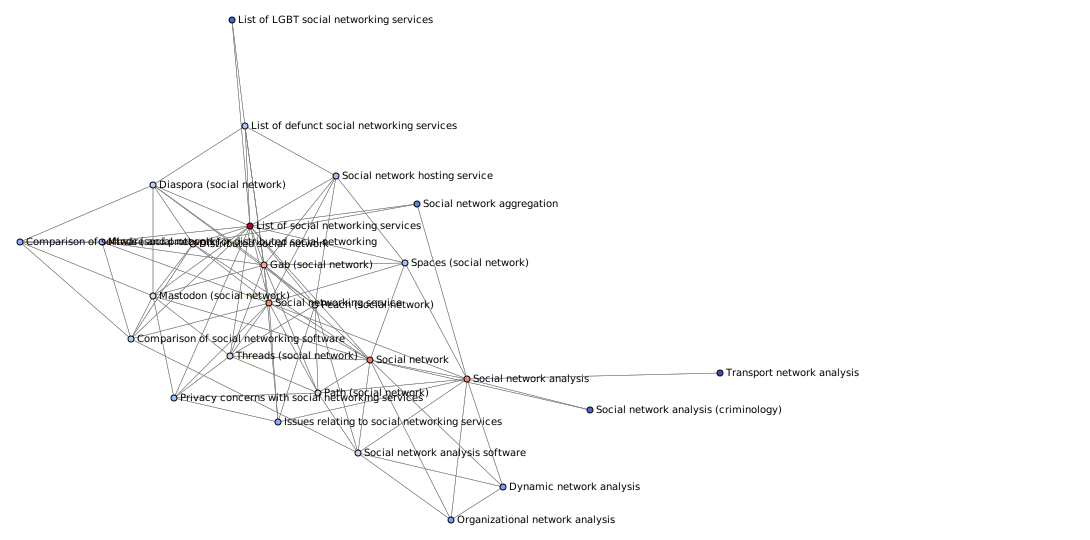

In [32]:
nodes = community_df[community_df['community']==comm_idx[4]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [33]:
[print(n) for n in sorted(G_comm.nodes)]

Comparison of social networking software
Comparison of software and protocols for distributed social networking
Complementary network service
Diaspora (social network)
Distributed social network
Dynamic network analysis
Gab (social network)
Issues relating to social networking services
List of LGBT social networking services
List of defunct social networking services
List of social networking services
Mastodon (social network)
Minds (social network)
Organizational network analysis
Path (social network)
Peach (social network)
Privacy concerns with social networking services
Professional network service
Social network
Social network aggregation
Social network analysis
Social network analysis (criminology)
Social network analysis software
Social network hosting service
Social networking service
Spaces (social network)
Threads (social network)
Transport network analysis


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

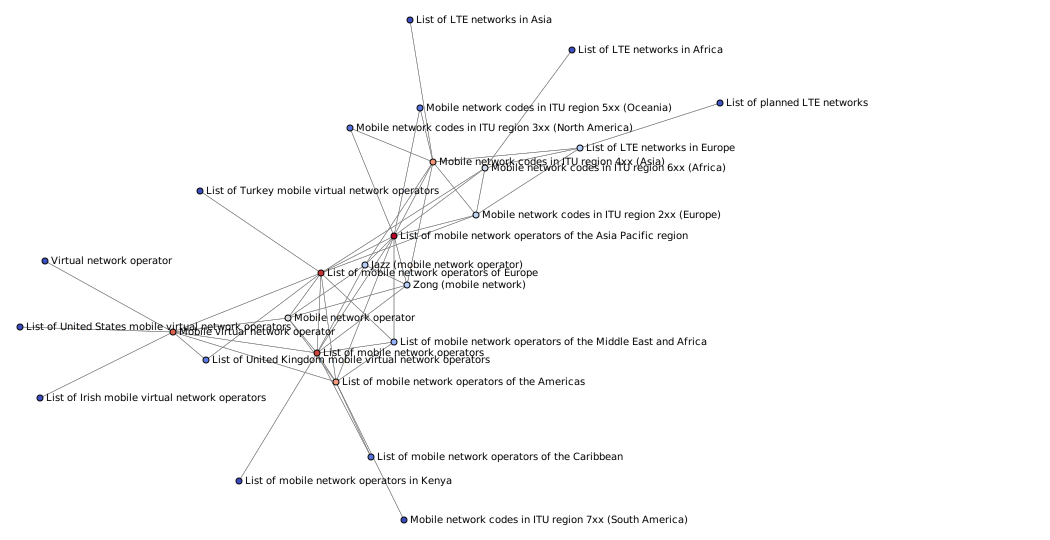

In [34]:
nodes = community_df[community_df['community']==comm_idx[5]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [35]:
[print(n) for n in sorted(G_comm.nodes)]

Jazz (mobile network operator)
List of Irish mobile virtual network operators
List of LTE networks in Africa
List of LTE networks in Asia
List of LTE networks in Europe
List of Turkey mobile virtual network operators
List of United Kingdom mobile virtual network operators
List of United States mobile virtual network operators
List of mobile network operators
List of mobile network operators in Kenya
List of mobile network operators of Europe
List of mobile network operators of the Americas
List of mobile network operators of the Asia Pacific region
List of mobile network operators of the Caribbean
List of mobile network operators of the Middle East and Africa
List of planned LTE networks
Mobile network codes in ITU region 2xx (Europe)
Mobile network codes in ITU region 3xx (North America)
Mobile network codes in ITU region 4xx (Asia)
Mobile network codes in ITU region 5xx (Oceania)
Mobile network codes in ITU region 6xx (Africa)
Mobile network codes in ITU region 7xx (South America)
Mo

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

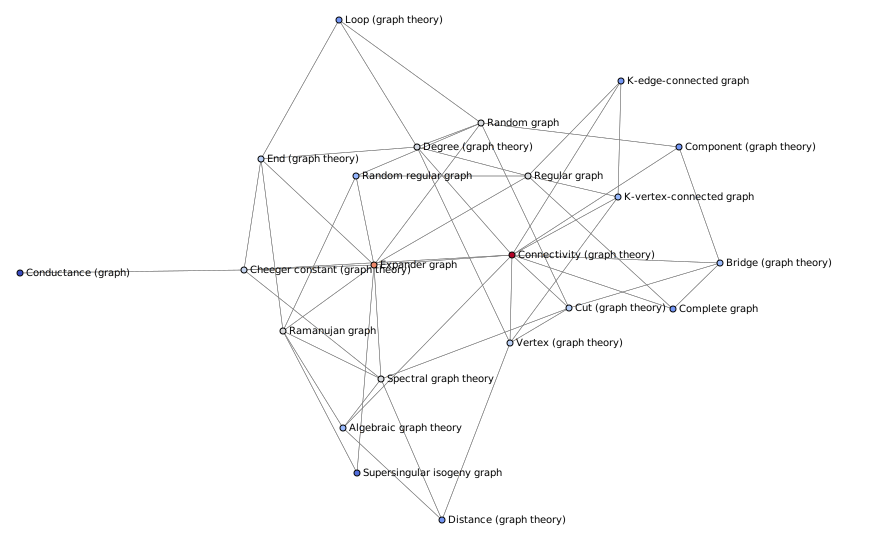

In [36]:
nodes = community_df[community_df['community']==comm_idx[6]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [37]:
[print(n) for n in sorted(G_comm.nodes)]

Algebraic graph theory
Berlekamp–Van Lint–Seidel graph
Bridge (graph theory)
Cheeger constant (graph theory)
Complete graph
Component (graph theory)
Conductance (graph)
Connectivity (graph theory)
Cut (graph theory)
Degree (graph theory)
Distance (graph theory)
End (graph theory)
Expander graph
K-edge-connected graph
K-vertex-connected graph
Loop (graph theory)
Multipartite graph
Phase-field models on graphs
Ramanujan graph
Random graph
Random regular graph
Regular graph
Spectral graph theory
Supersingular isogeny graph
Two-graph
Vertex (graph theory)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

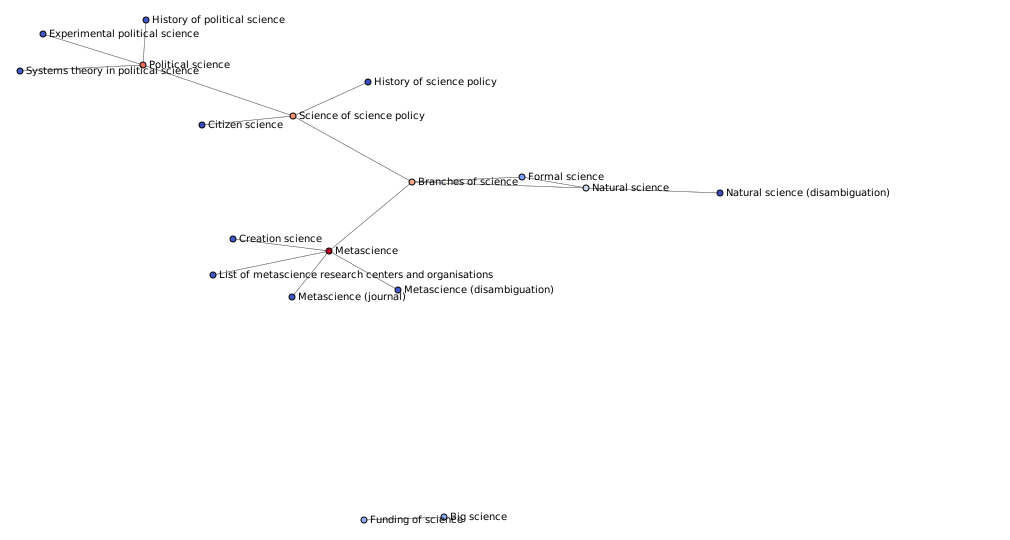

In [38]:
nodes = community_df[community_df['community']==comm_idx[7]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [39]:
[print(n) for n in sorted(G_comm.nodes)]

Big science
Branches of science
Citizen science
Computer science (disambiguation)
Conservation science
Creation science
Experimental political science
Formal science
Funding of science
History of political science
History of science and technology
History of science and technology in Japan
History of science policy
List of metascience research centers and organisations
Metascience
Metascience (disambiguation)
Metascience (journal)
Natural science
Natural science (disambiguation)
Political science
Rocket science
Science of science policy
Systems theory in political science
Vedic science


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

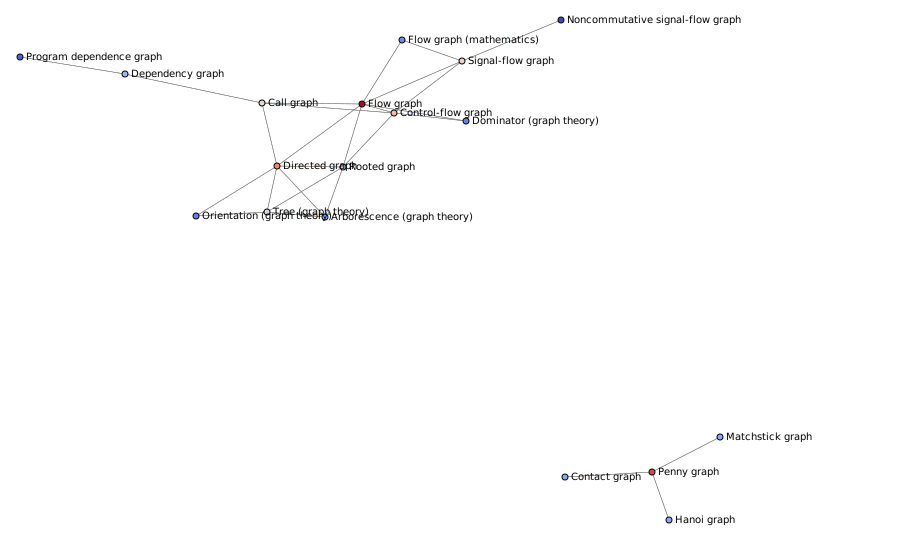

In [40]:
nodes = community_df[community_df['community']==comm_idx[8]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [41]:
[print(n) for n in sorted(G_comm.nodes)]

Arborescence (graph theory)
Call graph
Contact graph
Control-flow graph
Dependency graph
Directed graph
Dominator (graph theory)
Engelbert Humperdinck discography
Flow graph
Flow graph (mathematics)
Hanoi graph
Magic graph
Matchstick graph
Noncommutative signal-flow graph
Orientation (graph theory)
Penny graph
Photographs & Memories
Prince singles discography
Program dependence graph
Rooted graph
Signal-flow graph
Tree (graph theory)
Typography (cartography)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

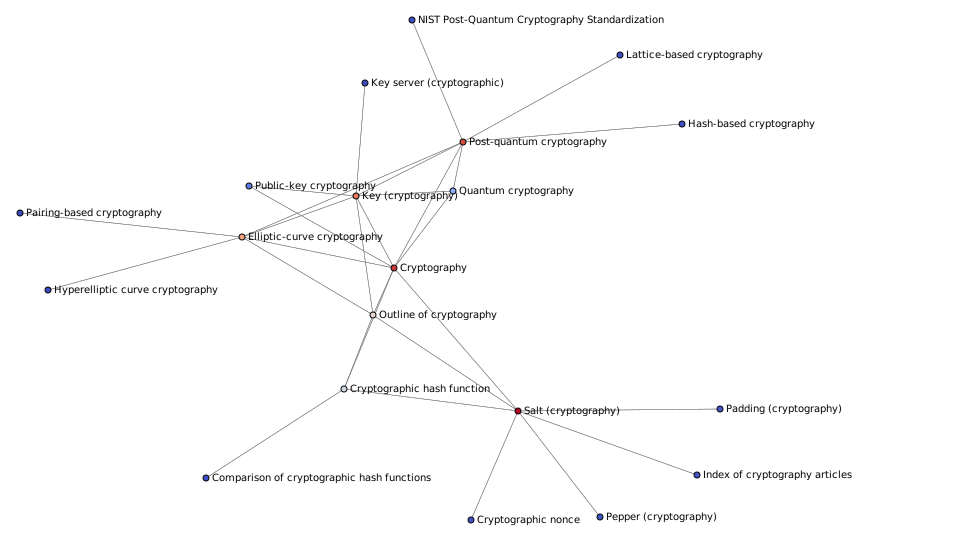

In [42]:
nodes = community_df[community_df['community']==comm_idx[9]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [43]:
[print(n) for n in sorted(G_comm.nodes)]

Comparison of cryptographic hash functions
Cryptographic hash function
Cryptographic key types
Cryptographic nonce
Cryptography
Elliptic-curve cryptography
Hash-based cryptography
Hyperelliptic curve cryptography
Index of cryptography articles
Key (cryptography)
Key server (cryptographic)
Lattice-based cryptography
List of cryptographers
NIST Post-Quantum Cryptography Standardization
Outline of cryptography
Padding (cryptography)
Pairing-based cryptography
Pepper (cryptography)
Post-quantum cryptography
Public-key cryptography
Quantum cryptography
Salt (cryptography)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## One More Time, on the Main Community

You can even zoom in on an individual community, if the previous community detection work wasn't quite satisfactory. Essentially, these are subcommunities in the largest network-related community.

In [44]:
partition = community_louvain.best_partition(G_net_main, resolution=1, random_state=1337) 

In [45]:
net_community_df = pd.DataFrame().from_dict(partition, orient='index')
net_community_df.reset_index(inplace=True)
net_community_df.columns = ['node', 'community']

net_community_df['community'].value_counts()[0:20]

2     29
0     27
4     21
3     17
7     15
8     13
6      9
5      7
9      1
10     1
11     1
12     1
13     1
14     1
15     1
1      1
Name: community, dtype: int64

In [46]:
comm_idx = net_community_df['community'].value_counts()[0:20].index.values

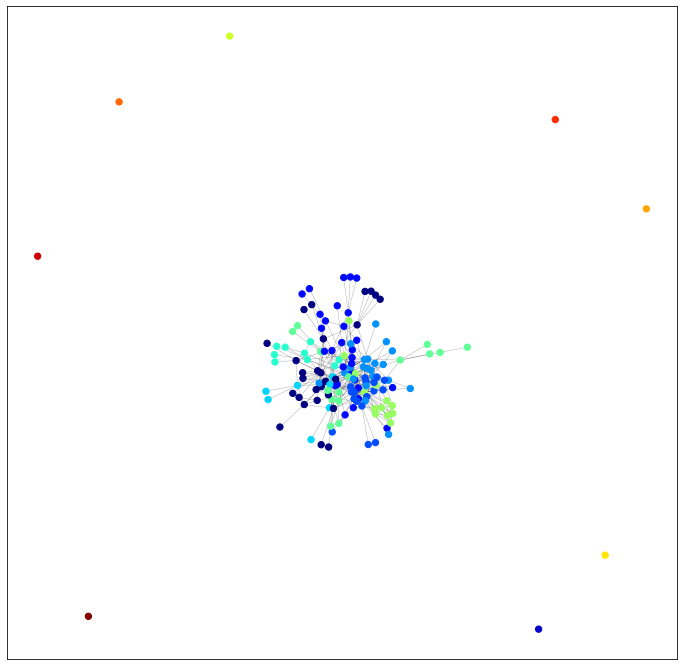

In [47]:
draw_partition(G_net_main, partition)

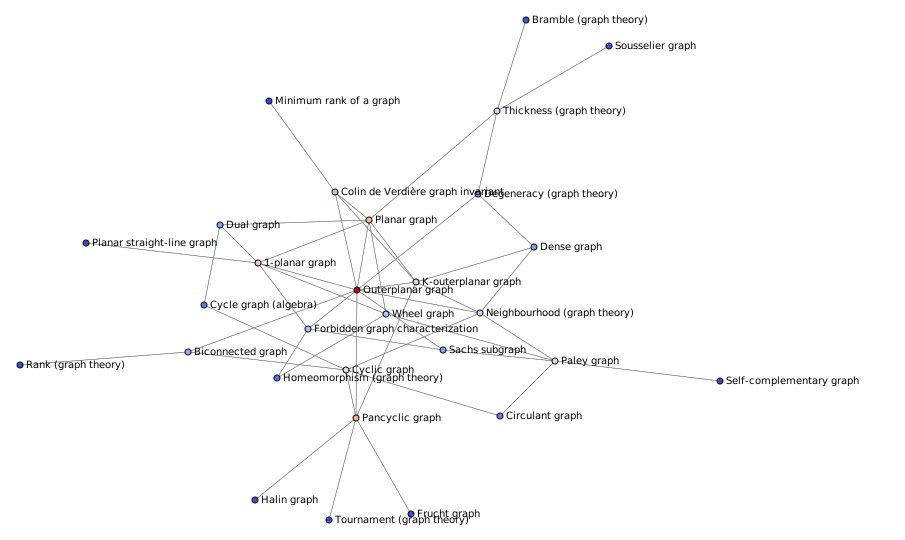

In [48]:
nodes = net_community_df[net_community_df['community']==comm_idx[0]]['node'].values

G_comm = G_net_main.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

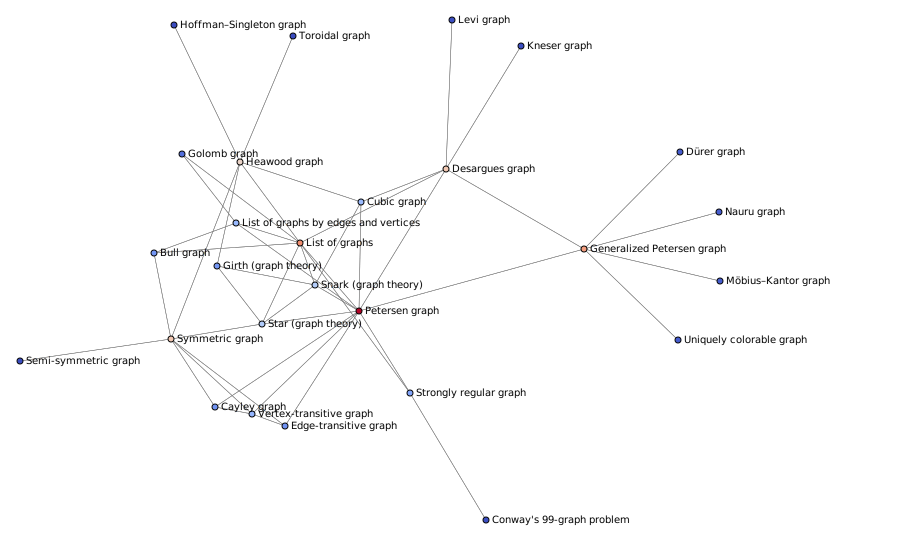

In [49]:
nodes = net_community_df[net_community_df['community']==comm_idx[1]]['node'].values

G_comm = G_net_main.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

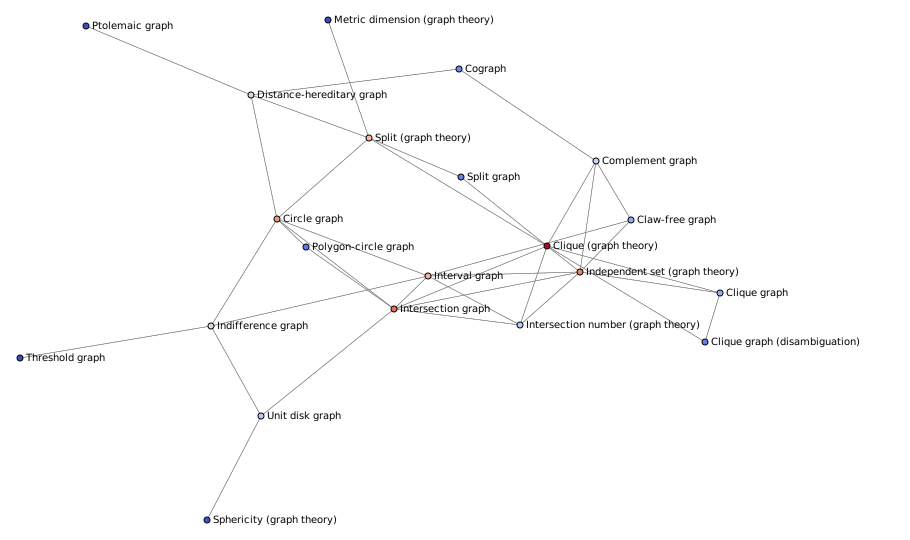

In [50]:
nodes = net_community_df[net_community_df['community']==comm_idx[2]]['node'].values

G_comm = G_net_main.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

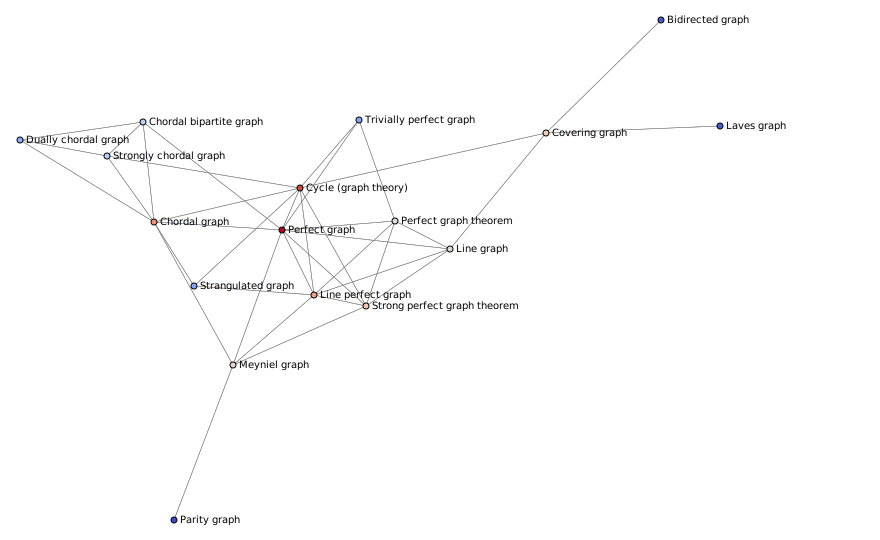

In [51]:
nodes = net_community_df[net_community_df['community']==comm_idx[3]]['node'].values

G_comm = G_net_main.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

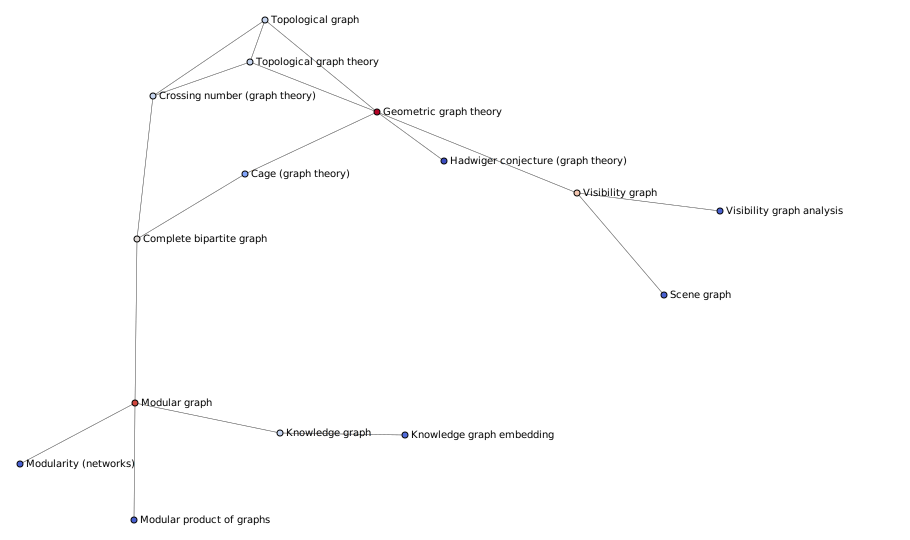

In [52]:
nodes = net_community_df[net_community_df['community']==comm_idx[4]]['node'].values

G_comm = G_net_main.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

# Power Law?

In most real-world networks, it will be that there are very many nodes with few degrees and very few nodes with many degrees. This is like the saying "rich get richer". Think about people on social media, for instance. Most people have some connections, but very few people have many (millions of) connections, and those people with many connections tend to grow their following much faster than everyone else.

This phenomenon doesn't just reveal itself on social media. It is at play in many real-world networks.

In [72]:
degree_df = pd.DataFrame().from_dict(G.degree)
degree_df.columns = ['node', 'degrees']
degree_df.set_index('node', inplace=True)
degree_df.head()

,degrees
node,
Network science,21
Hub (network science),10
Network theory,27
National Science Foundation Network,11
Efficiency (network science),8


<AxesSubplot:ylabel='Frequency'>

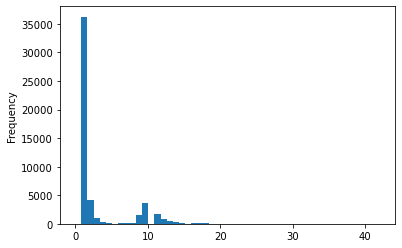

In [73]:
degree_df['degrees'].plot.hist(bins=50)

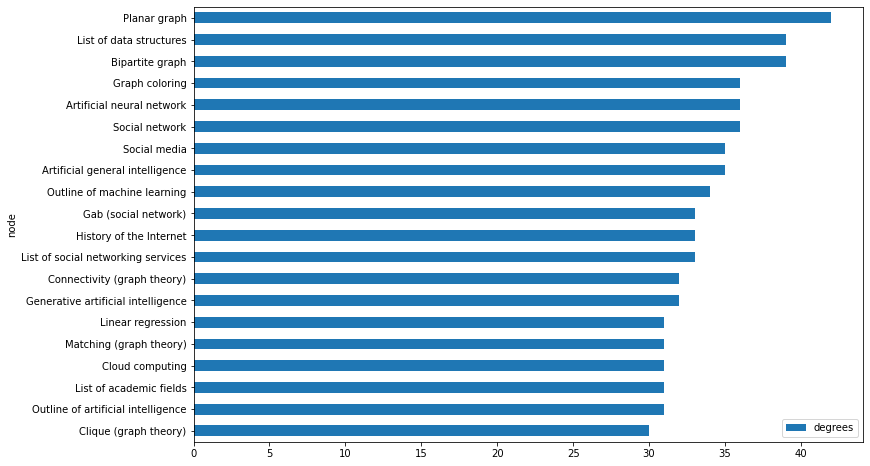

In [77]:
degree_df.sort_values('degrees', ascending=False)[0:20].plot.barh(figsize=(12,8)).invert_yaxis()

We could repeat the above steps with just the network sciece related graph and we would probably see the same phenomenon: a few nodes with many edges and many nodes with a few edges. Let's see!

In [78]:
degree_df = pd.DataFrame().from_dict(G_net_main.degree)
degree_df.columns = ['node', 'degrees']
degree_df.set_index('node', inplace=True)
degree_df.head()

,degrees
node,
Hoffman–Singleton graph,1
Visibility graph,5
Halin graph,1
1-planar graph,7
Meyniel graph,6


<AxesSubplot:ylabel='Frequency'>

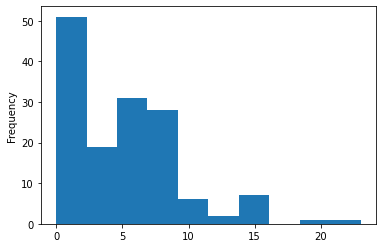

In [82]:
degree_df['degrees'].plot.hist(bins=10)

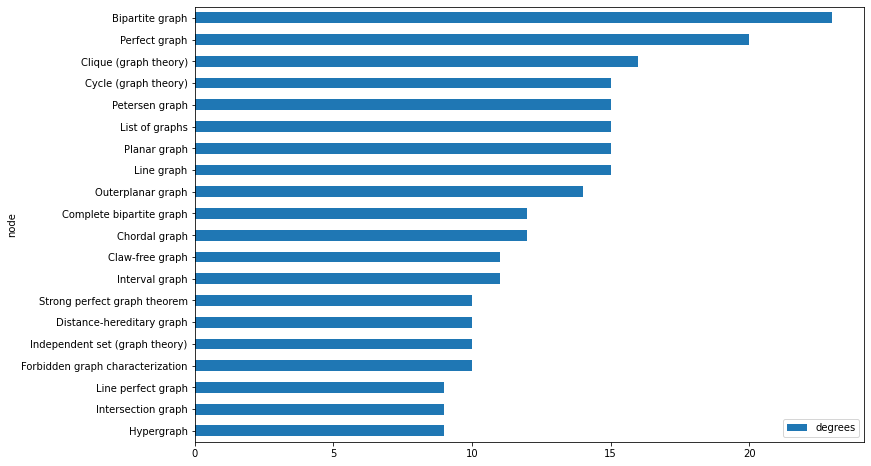

In [83]:
degree_df.sort_values('degrees', ascending=False)[0:20].plot.barh(figsize=(12,8)).invert_yaxis()

It isn't quite as extreme, and the graph is still small, but the phenomenon is there. There are may nodes with 0-10 edges, and far fewer with more than ten.

We'll explore this concept more throughout this adventure. I just wanted to take a look.